In [1]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from db import helper as db_helper
from common import treat_data, extract_period_returns, reshape_df, extract_price_volatility
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
session = db_helper.start_session()
df = pd.read_sql_table('spot_rates', session.bind)

2019-05-08 21:45:27,781 INFO sqlalchemy.engine.base.Engine select version()
2019-05-08 21:45:27,783 INFO sqlalchemy.engine.base.Engine {}
2019-05-08 21:45:27,788 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-05-08 21:45:27,789 INFO sqlalchemy.engine.base.Engine {}
2019-05-08 21:45:27,792 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-08 21:45:27,794 INFO sqlalchemy.engine.base.Engine {}
2019-05-08 21:45:27,798 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-08 21:45:27,799 INFO sqlalchemy.engine.base.Engine {}
2019-05-08 21:45:27,800 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-05-08 21:45:27,804 INFO sqlalchemy.engine.base.Engine {}
2019-05-08 21:45:27,807 INFO sqlalchemy.engine.base.Engine SELECT c.relname FROM pg_class c JOIN pg_namespace n ON n.oid = c.relnamespace WHERE n.nspname = %(schema)s AND c.relkind = 'r'
2019-05-08 21:

2019-05-08 21:45:27,943 INFO sqlalchemy.engine.base.Engine {}


/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
df = treat_data(df)
# Split DF by currency
gbp_df = df[(df['base_currency']=='GBP')]
usd_df = df[(df['base_currency']=='USD')]
eur_df = df[(df['base_currency']=='EUR')]

df = extract_period_returns(gbp_df)
df = extract_price_volatility(df)
df = reshape_df(df)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/JaiPancholi/Sites/currency_analysis/notebooks/common.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  currency_df['weekly_spot_rate_volatility'] = currency_df.rolling(

In [4]:
df = df.dropna()
# target_variable = 'USD_one_year_future_return'
target_variable = 'USD_one_month_future_return'
X = df.drop(columns=[target_variable, 'date'])
y = df[target_variable]
cols_to_drop = [col for col in X.columns if col.endswith('future_return')]
X = X.drop(columns=cols_to_drop)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
X_r = pca.fit(X).transform(X)
sns.lineplot(x=range(X.shape[1]), y=pca.explained_variance_ratio_.cumsum())

In [ ]:
sns.scatterplot(x=X_r[:, 0], y=y)

In [ ]:
sns.scatterplot(x=X_r[:, 1], y=y)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Text(0.5,1,'R-Squared on Models Predicting Monthly Return on GBP:USD Rate')

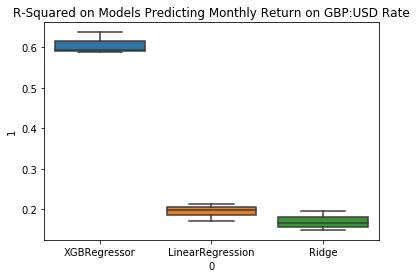

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

models = [
    XGBRegressor(),
    LinearRegression(),
    Ridge(),
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

k_folds = 3
model_scores = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='r2', cv=k_folds)
    for accuracy in accuracies:
        model_scores.append([model_name, accuracy])

df = pd.DataFrame(model_scores)
ax = sns.boxplot(x=0, y=1, data=df)
ax.set_title('R-Squared on Models Predicting Monthly Return on GBP:USD Rate')

In [16]:
# Hyper paramter tuning
from sklearn.model_selection import GridSearchCV
model = XGBRegressor()
params = {
	'learning_rate': [0.05, 0.1, 0.2],
	'n_estimators': [80, 100, 120, 150],
# 	'min_child_weight': [1, 5, 10],
# 	'gamma': [0.5, 1, 1.5, 2, 5],
# 	'subsample': [0.6, 0.8, 1.0],
# 	'colsample_bytree': [0.6, 0.8, 1.0],
	'max_depth': [3, 4, 5]
	}
grid_search = GridSearchCV(estimator=model, scoring='r2', cv=2, param_grid=params)
grid_search.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/x

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/x

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [80, 100, 120, 150], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [17]:
print(grid_search.best_score_, grid_search.best_params_)

0.8312798871619188 {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150}


In [ ]:
XGBRegressor(max_deph=5, learning_rate=0.2, n_estimators=120)

In [ ]:
from sklearn.metrics import r2_score
model = XGBRegressor()
model.fit(X_train, y_train)
y_test_hat = model.predict(X_test)
print(r2_score(y_test, y_test_hat))

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[1,:], matplotlib=True)
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:], matplotlib=True)
shap.force_plot(explainer.expected_value, shap_values[500,:], X_test.iloc[500,:], matplotlib=True)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
import numpy as np
y_class = np.where(y < 0, 'Negative Return', 'Non-negative Return')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

models = [
    XGBClassifier(),
    LinearSVC(),
#     MultinomialNB(),
#     LogisticRegression(random_state=0),
    RandomForestClassifier()
]

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.20, random_state=42)

k_folds = 3
model_scores = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=k_folds)
    for accuracy in accuracies:
        model_scores.append([model_name, accuracy])

df = pd.DataFrame(model_scores)
ax = sns.boxplot(x=0, y=1, data=df)
ax.set_title('R-Squared on Models Predicting Sign of Monthly Return on GBP:USD Rate ')

NameError: name 'y_class' is not defined

In [ ]:
from sklearn.metrics import accuracy_score
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_test_hat = model.predict(X_test)
print(accuracy_score(y_test, y_test_hat))

In [ ]:
np.unique(y_class, return_counts=True)

In [ ]:
from sklearn.metrics import confusion_matrix
labels = np.unique(y_class)
cm = confusion_matrix(y_test, y_test_hat, labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Consusion Matrix of Classifying Sign of Monthly Return on GBP:USD')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_test_hat))